In [1]:
import pandas as pd
import json
import numpy as np

In [2]:
file = 'attention_matrices/metadata.json'

with open(file, 'r') as f:
    data = json.load(f)
df = pd.DataFrame(data)
df.columns


FileNotFoundError: [Errno 2] No such file or directory: 'attention_matrices/metadata.json'

In [13]:
# df['num_nodes'].value_counts()
df['num_edges'].value_counts()

num_edges
21    33
20    31
19    31
17    27
22    25
18    23
23    22
16    22
25    17
24    12
15    10
27     9
26     7
14     7
28     6
29     5
30     4
13     3
12     2
10     2
9      2
Name: count, dtype: int64

Metadata JSON was a list; extracted the first dictionary element.
Successfully processed metadata from: /Users/log/Github/Spring2025Classes/social_networks/final_project/attention_matrices/arg_3_avg/metadata.json
Constructed full path to attention matrix: attention_matrices/arg_3_avg/avg_attn_0.npy
Successfully loaded attention matrix from: attention_matrices/arg_3_avg/avg_attn_0.npy
Final attention matrix shape for plotting: (69, 69)

Number of tokens (69) matches attention matrix dimensions (69x69).

Generating plot...

Saved plot to: attention_matrix_from_metadata.png


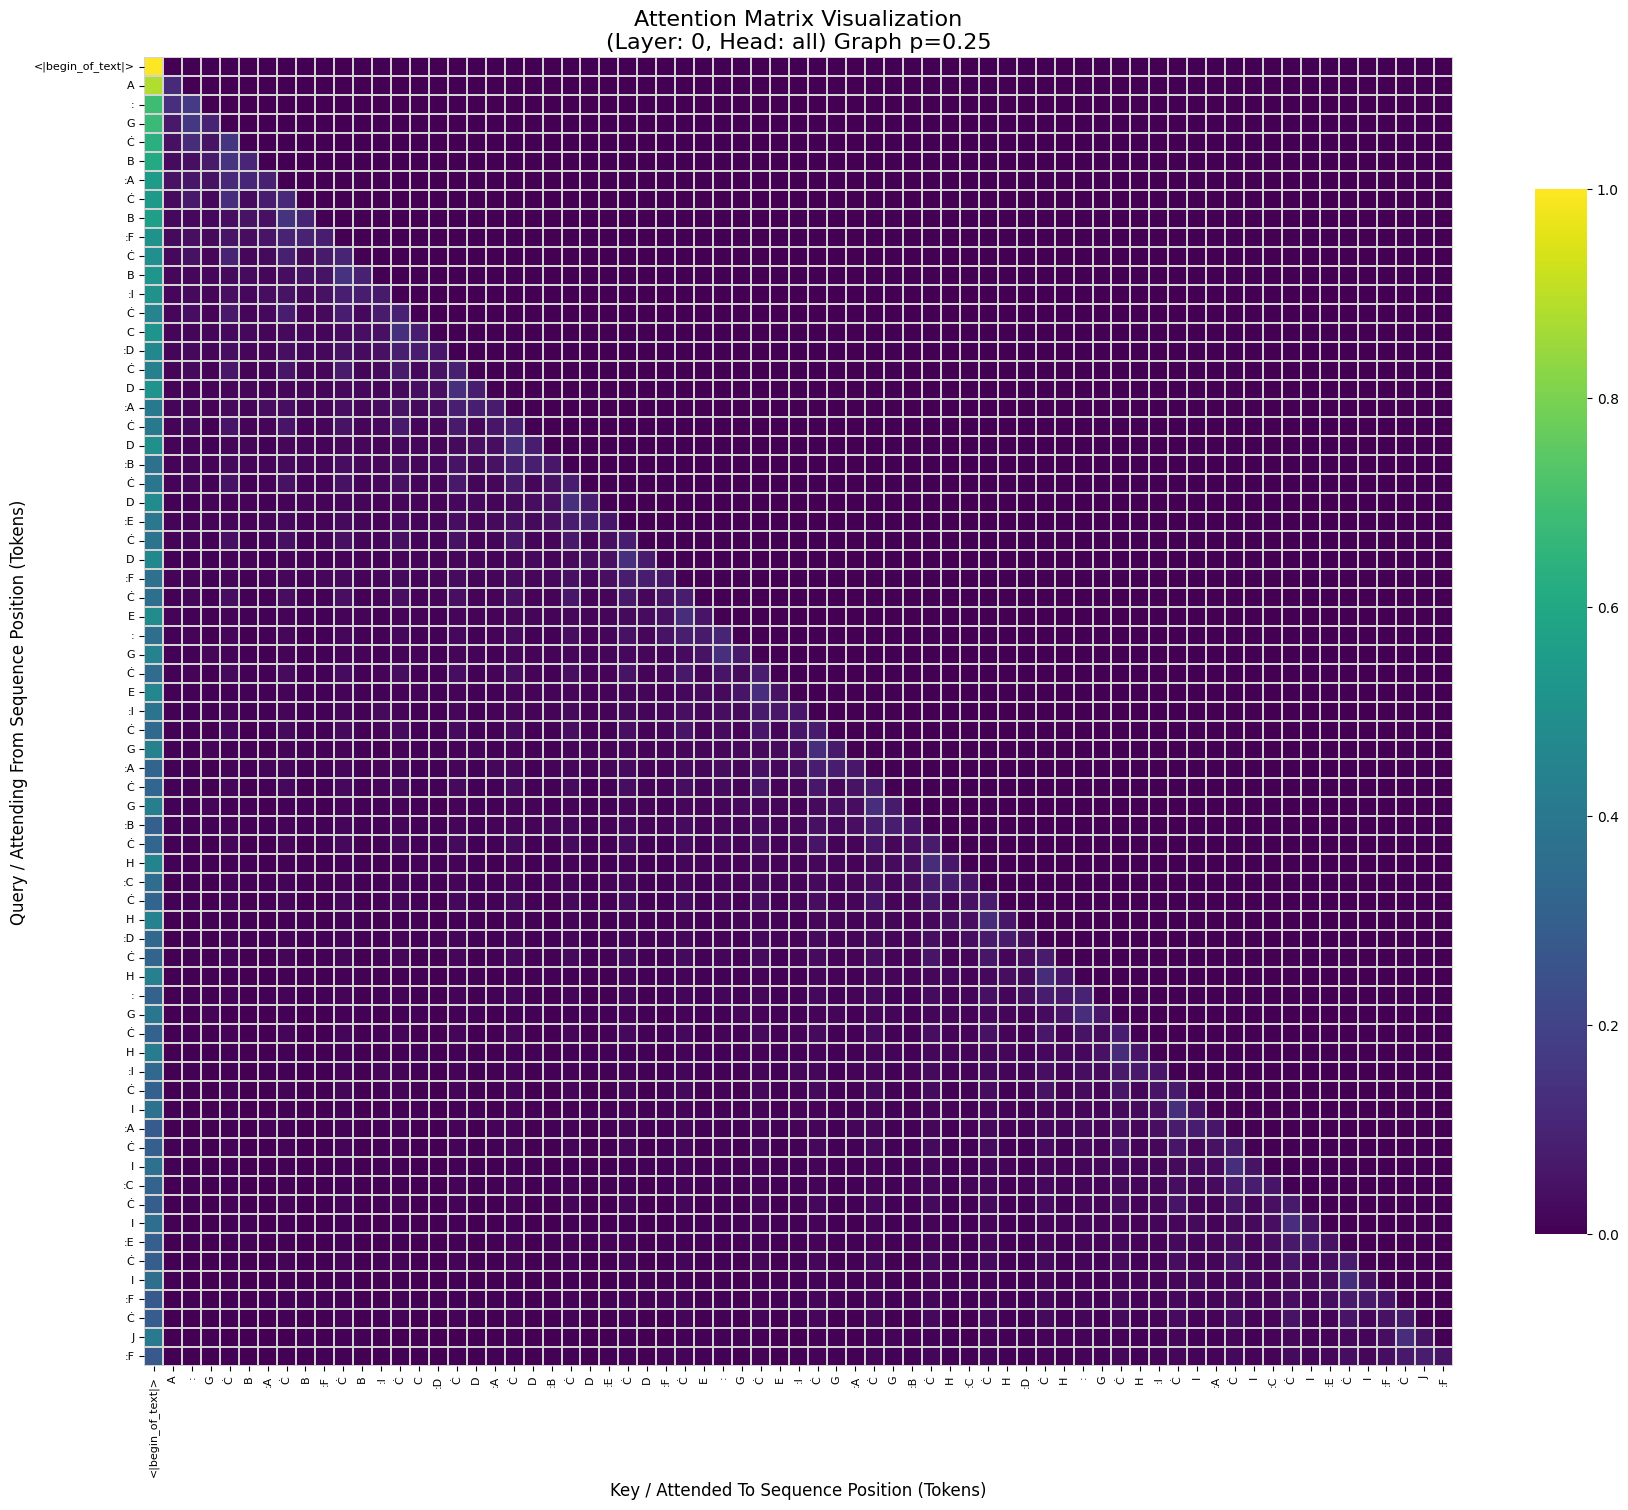


Script finished.


In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os # Needed for path manipulation

# --- Configuration ---
metadata_file_path = '/Users/log/Github/Spring2025Classes/social_networks/final_project/attention_matrices/arg_3_avg/metadata.json'
output_plot_filename = 'attention_matrix_from_metadata.png'
# ---

# 1. Read Metadata from JSON file
try:
    with open(metadata_file_path, 'r') as f:
        # Load whatever the top-level structure is
        raw_metadata = json.load(f)

    # *** MODIFICATION START ***
    # Check if the loaded data is a list
    if isinstance(raw_metadata, list):
        if len(raw_metadata) > 0 and isinstance(raw_metadata[0], dict):
            # If it's a non-empty list and the first item is a dictionary, use that item
            metadata = raw_metadata[0]
            print("Metadata JSON was a list; extracted the first dictionary element.")
        else:
            # Handle cases like an empty list or a list not containing a dict at index 0
            raise ValueError("Metadata JSON is a list, but it's empty or the first element isn't a dictionary.")
    elif isinstance(raw_metadata, dict):
        # If it's already a dictionary, use it directly
        metadata = raw_metadata
        print("Metadata JSON was already a dictionary.")
    else:
        # If it's neither a list nor a dictionary (unlikely for valid JSON, but good to check)
        raise ValueError(f"Unexpected data type loaded from JSON: {type(raw_metadata)}. Expected dict or list containing a dict.")
    # *** MODIFICATION END ***

    print(f"Successfully processed metadata from: {metadata_file_path}")

    # Extract necessary information USING the 'metadata' dictionary
    attention_matrix_relative_path = metadata.get("attention_matrix_path")
    tokens = metadata.get("tokens")
    layer = metadata.get("layer", "N/A") # Default if not found
    head = metadata.get("head", "N/A")   # Default if not found

    # Basic validation
    if not attention_matrix_relative_path:
        raise ValueError("Metadata dictionary missing 'attention_matrix_path' key.")
    if not tokens:
        raise ValueError("Metadata dictionary missing 'tokens' key or it's empty.")
    if not isinstance(tokens, list):
        raise ValueError("'tokens' key in metadata dictionary must be a list.")

except FileNotFoundError:
    print(f"Error: Metadata file not found at {metadata_file_path}")
    exit()
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {metadata_file_path}. Check file format.")
    exit()
except ValueError as ve: # Catches ValueErrors raised in the loading/checking logic
    print(f"Error processing metadata structure: {ve}")
    exit()
except Exception as e: # Catch other potential errors during loading/parsing
    print(f"An unexpected error occurred while reading or processing metadata: {e}")
    exit()

# 2. Construct the full path to the attention matrix
# Assume the path in the JSON is relative to the JSON file's directory
json_directory = os.path.dirname(metadata_file_path)
attention_matrix_full_path = os.path.join(attention_matrix_relative_path)
# Normalize the path (optional, but good practice for consistency)
attention_matrix_full_path = os.path.normpath(attention_matrix_full_path)

print(f"Constructed full path to attention matrix: {attention_matrix_full_path}")

# 3. Load the attention matrix
try:
    attention_matrix = np.load(attention_matrix_full_path)
    print(f"Successfully loaded attention matrix from: {attention_matrix_full_path}")
except FileNotFoundError:
    print(f"\nError: Could not find the attention matrix file at the constructed path:")
    print(f"  -> {attention_matrix_full_path}")
    print(f"Please ensure the 'attention_matrix_path' ('{attention_matrix_relative_path}') in '{os.path.basename(metadata_file_path)}' is correct relative to its location.")
    exit()
except Exception as e:
    print(f"An error occurred while loading the numpy array: {e}")
    exit()

# 4. Preprocessing and Validation (Same as before)
if attention_matrix.ndim > 2:
    print(f"Original attention matrix shape: {attention_matrix.shape}")
    if attention_matrix.shape[0] == 1 and attention_matrix.ndim == 3:
         attention_matrix = np.squeeze(attention_matrix, axis=0)
         print(f"Squeezed extra dimension, new shape: {attention_matrix.shape}")

if attention_matrix.ndim != 2:
    print(f"Error: Attention matrix is not 2D after potential reshaping. Final shape is {attention_matrix.shape}")
    print("Cannot proceed with 2D heatmap plotting.")
    exit()

print(f"Final attention matrix shape for plotting: {attention_matrix.shape}")

num_tokens = len(tokens)
matrix_dim1, matrix_dim2 = attention_matrix.shape

if num_tokens != matrix_dim1 or num_tokens != matrix_dim2:
    print(f"\n--- WARNING ---")
    print(f"Mismatch between number of tokens in metadata ({num_tokens}) and")
    print(f"attention matrix dimensions ({matrix_dim1}x{matrix_dim2}).")
    print("The plot labels might not correctly correspond to the matrix axes.")
    print(f"Proceeding with plotting using {num_tokens} token labels...")
else:
    print(f"\nNumber of tokens ({num_tokens}) matches attention matrix dimensions ({matrix_dim1}x{matrix_dim2}).")

# 5. Plotting (Same as before)
print("\nGenerating plot...")

plt.figure(figsize=(18, 16))
sns.heatmap(attention_matrix,
            cmap='viridis',
            square=True,
            linewidths=0.01,
            linecolor='lightgrey',
            cbar_kws={"shrink": 0.7},
            xticklabels=tokens,
            yticklabels=tokens)

title = f'Attention Matrix Visualization\n(Layer: {layer}, Head: {head})'
if "connection_probability" in metadata:
     title += f' Graph p={metadata.get("connection_probability", "N/A")}' # Use .get for safety
plt.title(title, fontsize=16)
plt.xlabel('Key / Attended To Sequence Position (Tokens)', fontsize=12)
plt.ylabel('Query / Attending From Sequence Position (Tokens)', fontsize=12)

plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
# try:
#     plt.savefig(output_plot_filename, dpi=300, bbox_inches='tight')
#     print(f"\nSaved plot to: {output_plot_filename}")
# except Exception as e:
#     print(f"\nError saving plot: {e}")

plt.show()

print("\nScript finished.")

In [1]:
print("test")

test
